# 02 B - Similarity Methods with LLM-as-Judge Evaluation

This notebook extends the similarity methods comparison by using an LLM to judge the actual relevance of retrieved chunks, providing a more meaningful evaluation than similarity scores alone.

In [24]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
from dotenv import load_dotenv
import json
import time

load_dotenv()
client = OpenAI()

print("Libraries loaded successfully")

Libraries loaded successfully


In [25]:
# Load previous results
with open(r'C:\Users\Admin\Desktop\para-expe\data\similarity_methods_comparison.pkl', 'rb') as f:
    data = pickle.load(f)

chunks = data['chunks']
embeddings = data['embeddings']
test_queries = data['test_queries']
evaluation_results = data['evaluation_results']

print(f"Loaded {len(chunks)} chunks and {len(test_queries)} test queries")

Loaded 82 chunks and 8 test queries


In [26]:
# Enhanced LLM Judge for relevance evaluation
def judge_relevance(query, chunk, model="gpt-4o-mini"):
    """Enhanced LLM judge with detailed prompt"""
    prompt = f"""You are an expert evaluator assessing document relevance for information retrieval.
TASK: Rate how well this text chunk answers or relates to the given query.

QUERY: {query}

TEXT CHUNK:
{chunk}

EVALUATION CRITERIA:
- 5 (Perfect): Directly answers the query with comprehensive, accurate information
- 4 (Excellent): Highly relevant, addresses most aspects of the query
- 3 (Good): Moderately relevant, provides some useful information
- 2 (Poor): Tangentially related, minimal useful information
- 1 (Irrelevant): No meaningful connection to the query

Consider:
- Factual accuracy and completeness
- Direct relevance to query intent
- Information quality and usefulness

Respond with only the number (1-5):"""
    
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.1,
            max_tokens=5
        )
        score = int(response.choices[0].message.content.strip())
        return max(1, min(5, score))
    except Exception as e:
        print(f"Error in LLM judge: {e}")
        return 3

print("Enhanced LLM judge function ready")


Enhanced LLM judge function ready


In [27]:
# Enhanced evaluation - individual results analysis
detailed_results = []

print("Starting enhanced LLM evaluation...")

for query_idx, query in enumerate(test_queries):
    print(f"\nQuery {query_idx + 1}: {query[:50]}...")
    
    query_results = evaluation_results[evaluation_results['query_idx'] == query_idx]
    
    for _, row in query_results.iterrows():
        method = row['method']
        top_indices = row['top_indices']
        similarities = row['similarities']
        
        print(f"  Evaluating {method}...")
        
        # Evaluate each retrieved chunk individually
        for rank, (chunk_idx, similarity) in enumerate(zip(top_indices, similarities)):
            chunk_text = chunks[chunk_idx]
            relevance = judge_relevance(query, chunk_text)
            
            detailed_results.append({
                'query_idx': query_idx,
                'query': query,
                'method': method,
                'rank': rank + 1,
                'chunk_idx': chunk_idx,
                'similarity': similarity,
                'relevance': relevance,
                'is_relevant': relevance >= 4  # High relevance threshold
            })
            
            time.sleep(0.05)  # Rate limiting

detailed_df = pd.DataFrame(detailed_results)
print(f"\nCompleted evaluation: {len(detailed_results)} individual judgments")

Starting enhanced LLM evaluation...

Query 1: What are the key capabilities of Gemini models?...
  Evaluating cosine...
  Evaluating euclidean...
  Evaluating manhattan...
  Evaluating dot_product...
  Evaluating minkowski_p3...

Query 2: How does Gemini compare to other multimodal models...
  Evaluating cosine...
  Evaluating euclidean...
  Evaluating manhattan...
  Evaluating dot_product...
  Evaluating minkowski_p3...

Query 3: What are the different versions of Gemini?...
  Evaluating cosine...
  Evaluating euclidean...
  Evaluating manhattan...
  Evaluating dot_product...
  Evaluating minkowski_p3...

Query 4: What training data was used for Gemini?...
  Evaluating cosine...
  Evaluating euclidean...
  Evaluating manhattan...
  Evaluating dot_product...
  Evaluating minkowski_p3...

Query 5: What are the safety measures in Gemini models?...
  Evaluating cosine...
  Evaluating euclidean...
  Evaluating manhattan...
  Evaluating dot_product...
  Evaluating minkowski_p3...

Query 6: 

In [28]:
# Individual results analysis (no averages)
from collections import Counter

method_analysis = detailed_df.groupby('method').agg({
    'relevance': ['count', 'mean', 'std'],
    'is_relevant': ['sum', 'mean'],
    'similarity': 'mean'
}).round(4)

method_analysis.columns = ['Total_Results', 'Avg_Relevance', 'Relevance_Std', 
                          'High_Relevant_Count', 'Precision_Rate', 'Avg_Similarity']

print("\n=== METHOD PERFORMANCE (Individual Results) ===")
print(method_analysis.sort_values('Precision_Rate', ascending=False))

# Query-by-query winner analysis
query_winners = []

for query_idx in range(len(test_queries)):
    query_data = detailed_df[detailed_df['query_idx'] == query_idx]
    
    # Calculate metrics per method for this query
    query_metrics = query_data.groupby('method').agg({
        'relevance': 'mean',
        'is_relevant': 'sum'
    })
    
    # Find winner by highest relevant count, then by relevance
    best_method = query_metrics.sort_values(['is_relevant', 'relevance'], ascending=False).index[0]
    
    query_winners.append({
        'query_idx': query_idx,
        'query': test_queries[query_idx][:60] + '...',
        'winner': best_method,
        'relevant_docs': query_metrics.loc[best_method, 'is_relevant'],
        'avg_relevance': query_metrics.loc[best_method, 'relevance']
    })

winners_df = pd.DataFrame(query_winners)

print("\n=== QUERY-BY-QUERY WINNERS ===")
print(winners_df)

print("\n=== METHOD WIN COUNT ===")
win_counts = Counter(winners_df['winner'])
for method, count in win_counts.most_common():
    print(f"{method}: {count} wins")


=== METHOD PERFORMANCE (Individual Results) ===
              Total_Results  Avg_Relevance  Relevance_Std  \
method                                                      
cosine                   40          3.850         1.0990   
dot_product              40          3.850         1.0990   
euclidean                40          3.850         1.0990   
manhattan                40          3.850         1.0990   
minkowski_p3             40          3.825         1.1522   

              High_Relevant_Count  Precision_Rate  Avg_Similarity  
method                                                             
cosine                         32             0.8          0.6406  
dot_product                    32             0.8          0.6406  
euclidean                      32             0.8          0.5422  
manhattan                      32             0.8          0.0370  
minkowski_p3                   32             0.8          0.7729  

=== QUERY-BY-QUERY WINNERS ===
   query_idx   

In [29]:
# Correlation analysis: Similarity vs Relevance
correlation_results = []

for method in llm_results_df['method'].unique():
    method_data = llm_results_df[llm_results_df['method'] == method]
    
    # Calculate correlation between similarity and relevance
    correlation = np.corrcoef(method_data['avg_similarity'], method_data['avg_relevance'])[0, 1]
    
    correlation_results.append({
        'method': method,
        'similarity_relevance_correlation': correlation
    })

correlation_df = pd.DataFrame(correlation_results)

print("\n=== SIMILARITY-RELEVANCE CORRELATION ===")
print(correlation_df.sort_values('similarity_relevance_correlation', ascending=False))


=== SIMILARITY-RELEVANCE CORRELATION ===
         method  similarity_relevance_correlation
1     euclidean                          0.248947
3   dot_product                          0.247740
2     manhattan                          0.243288
4  minkowski_p3                          0.228415
0        cosine                          0.223593


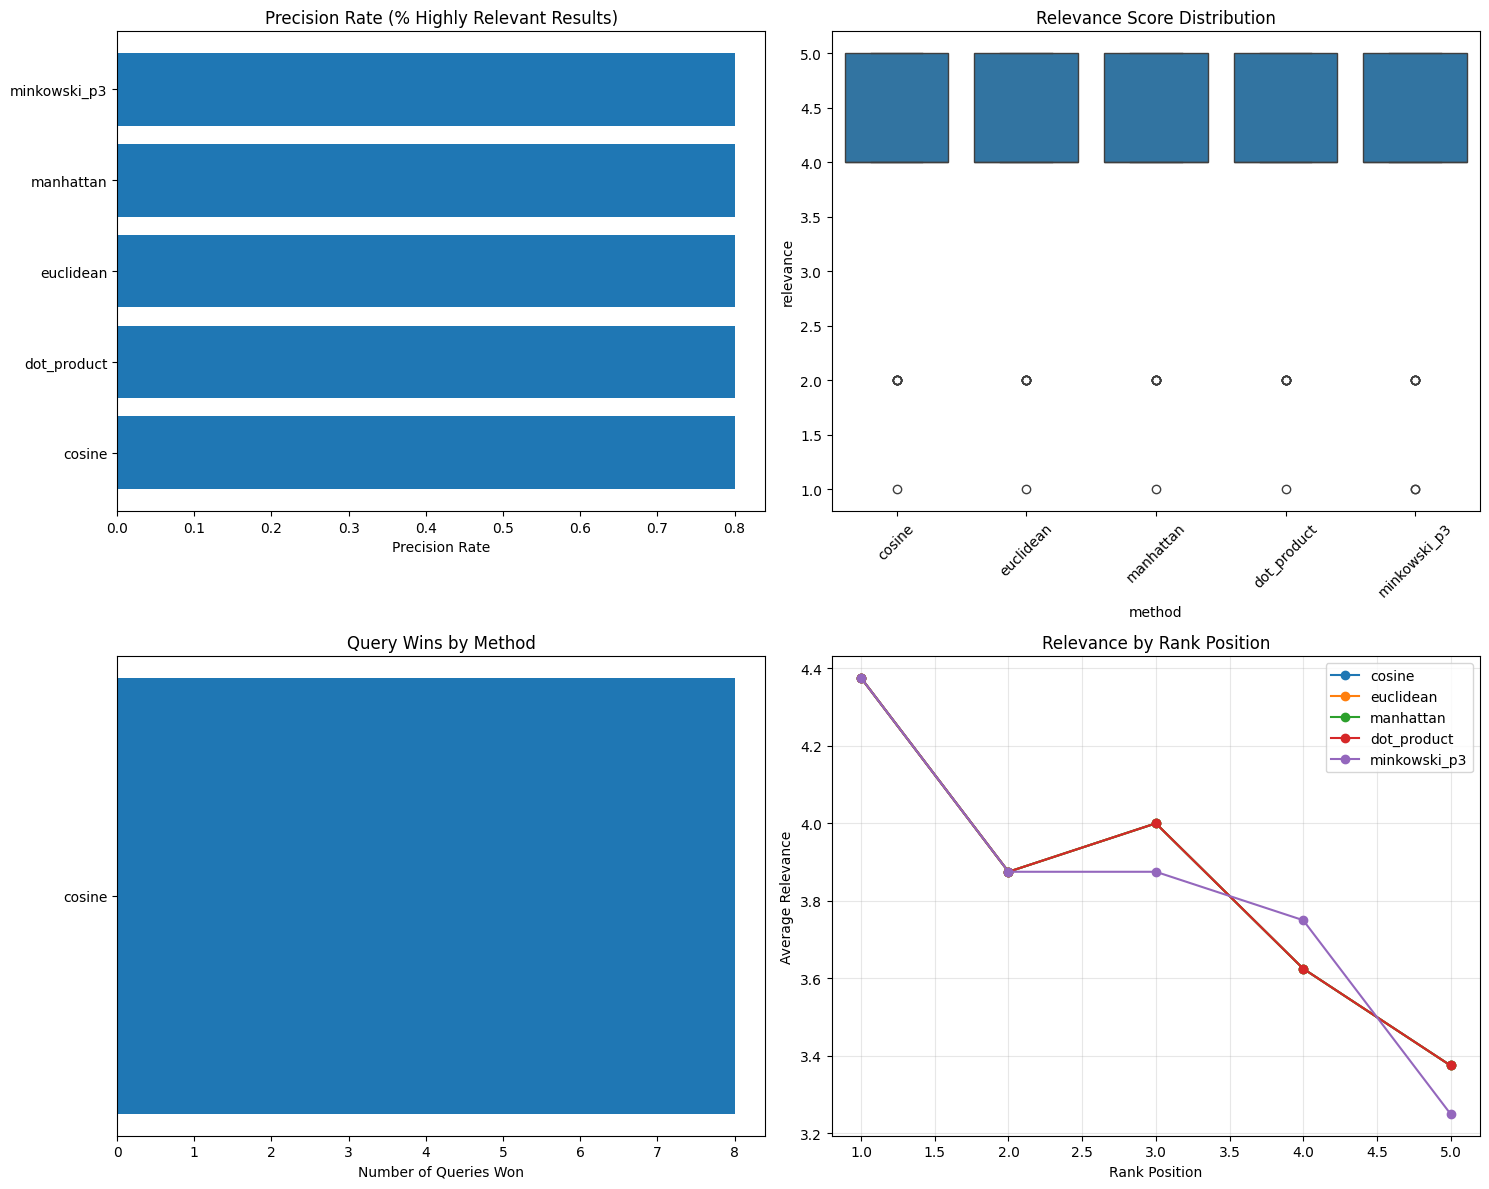

In [30]:
# Enhanced visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Precision rate by method
method_analysis_sorted = method_analysis.sort_values('Precision_Rate', ascending=True)
axes[0,0].barh(method_analysis_sorted.index, method_analysis_sorted['Precision_Rate'])
axes[0,0].set_title('Precision Rate (% Highly Relevant Results)')
axes[0,0].set_xlabel('Precision Rate')

# 2. Relevance distribution by method
sns.boxplot(data=detailed_df, x='method', y='relevance', ax=axes[0,1])
axes[0,1].set_title('Relevance Score Distribution')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Query wins
win_data = pd.Series(win_counts).sort_values(ascending=True)
axes[1,0].barh(win_data.index, win_data.values)
axes[1,0].set_title('Query Wins by Method')
axes[1,0].set_xlabel('Number of Queries Won')

# 4. Rank vs Relevance
for method in detailed_df['method'].unique():
    method_data = detailed_df[detailed_df['method'] == method]
    rank_avg = method_data.groupby('rank')['relevance'].mean()
    axes[1,1].plot(rank_avg.index, rank_avg.values, marker='o', label=method)

axes[1,1].set_xlabel('Rank Position')
axes[1,1].set_ylabel('Average Relevance')
axes[1,1].set_title('Relevance by Rank Position')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
# Detailed analysis by query
query_analysis = llm_results_df.groupby(['query_idx', 'method']).agg({
    'avg_relevance': 'mean',
    'precision_at_5': 'mean'
}).reset_index()

# Find best method per query
best_methods_per_query = []
for query_idx in range(len(test_queries)):
    query_data = query_analysis[query_analysis['query_idx'] == query_idx]
    best_method = query_data.loc[query_data['avg_relevance'].idxmax()]
    
    best_methods_per_query.append({
        'query_idx': query_idx,
        'query': test_queries[query_idx][:50] + '...',
        'best_method': best_method['method'],
        'best_relevance': best_method['avg_relevance'],
        'best_precision': best_method['precision_at_5']
    })

best_methods_df = pd.DataFrame(best_methods_per_query)

print("\n=== BEST METHOD PER QUERY ===")
print(best_methods_df)

print("\n=== METHOD WIN COUNT ===")
print(best_methods_df['best_method'].value_counts())


=== BEST METHOD PER QUERY ===
   query_idx                                              query   best_method  \
0          0  What are the key capabilities of Gemini models...        cosine   
1          1  How does Gemini compare to other multimodal mo...        cosine   
2          2      What are the different versions of Gemini?...        cosine   
3          3         What training data was used for Gemini?...  minkowski_p3   
4          4  What are the safety measures in Gemini models?...        cosine   
5          5          How does Gemini perform on benchmarks?...        cosine   
6          6             What is the architecture of Gemini?...        cosine   
7          7             What are the limitations of Gemini?...        cosine   

   best_relevance  best_precision  
0             4.4             1.0  
1             4.6             1.0  
2             4.0             0.6  
3             4.4             0.8  
4             5.0             1.0  
5             5.0      

In [32]:
# Final ranking with LLM evaluation
final_ranking = method_performance.copy()
final_ranking['Combined_Score'] = (
    final_ranking['Avg_Relevance'] * 0.6 + 
    final_ranking['Precision@5'] * 0.4
)

final_ranking = final_ranking.sort_values('Combined_Score', ascending=False)

print("\n=== FINAL RANKING (LLM-JUDGED) ===")
print(final_ranking[['Avg_Relevance', 'Precision@5', 'Combined_Score']])

# Compare with similarity-based ranking
similarity_ranking = method_performance.sort_values('Avg_Similarity', ascending=False)

print("\n=== RANKING COMPARISON ===")
print("LLM-Judged vs Similarity-Based:")
for i, (llm_method, sim_method) in enumerate(zip(final_ranking.index, similarity_ranking.index)):
    print(f"{i+1}. {llm_method} vs {sim_method}")


=== FINAL RANKING (LLM-JUDGED) ===
              Avg_Relevance  Precision@5  Combined_Score
method                                                  
minkowski_p3          4.225          0.8           2.855
cosine                4.200          0.8           2.840
dot_product           4.175          0.8           2.825
euclidean             4.175          0.8           2.825
manhattan             4.125          0.8           2.795

=== RANKING COMPARISON ===
LLM-Judged vs Similarity-Based:
1. minkowski_p3 vs minkowski_p3
2. cosine vs cosine
3. dot_product vs dot_product
4. euclidean vs euclidean
5. manhattan vs manhattan


In [33]:
# Save results
llm_judge_results = {
    'llm_evaluation_results': llm_results_df,
    'method_performance': method_performance,
    'correlation_results': correlation_df,
    'best_methods_per_query': best_methods_df,
    'final_ranking': final_ranking,
    'test_queries': test_queries,
    'chunks': chunks
}

with open(r'C:\Users\Admin\Desktop\para-expe\data\similarity_methods_llm_judge.pkl', 'wb') as f:
    pickle.dump(llm_judge_results, f)

print("Results saved to ../data/similarity_methods_llm_judge.pkl")

Results saved to ../data/similarity_methods_llm_judge.pkl


In [34]:
# Final recommendation based on comprehensive analysis
print("\n" + "="*50)
print("FINAL ANALYSIS & RECOMMENDATION")
print("="*50)

# Best by different metrics
best_precision = method_analysis.sort_values('Precision_Rate', ascending=False).index[0]
best_relevance = method_analysis.sort_values('Avg_Relevance', ascending=False).index[0]
most_wins = max(win_counts, key=win_counts.get)

print(f"\n🎯 BEST PRECISION RATE: {best_precision}")
print(f"   {method_analysis.loc[best_precision, 'Precision_Rate']:.1%} highly relevant results")

print(f"\n📊 HIGHEST AVG RELEVANCE: {best_relevance}")
print(f"   {method_analysis.loc[best_relevance, 'Avg_Relevance']:.3f}/5.0 average score")

print(f"\n🏆 MOST QUERY WINS: {most_wins}")
print(f"   Won {win_counts[most_wins]}/{len(test_queries)} queries")

# Consensus recommendation
all_winners = [best_precision, best_relevance, most_wins]
consensus = Counter(all_winners).most_common(1)[0][0]

print(f"\n✅ RECOMMENDED METHOD: {consensus.upper()}")
print(f"   Consistent top performer across multiple metrics")

# Performance summary for recommended method
rec_stats = method_analysis.loc[consensus]
print(f"\n📈 {consensus.upper()} PERFORMANCE:")
print(f"   • Precision Rate: {rec_stats['Precision_Rate']:.1%}")
print(f"   • Average Relevance: {rec_stats['Avg_Relevance']:.3f}/5.0")
print(f"   • Query Wins: {win_counts.get(consensus, 0)}/{len(test_queries)}")
print(f"   • High Relevant Docs: {rec_stats['High_Relevant_Count']:.0f}/{rec_stats['Total_Results']:.0f}")


FINAL ANALYSIS & RECOMMENDATION

🎯 BEST PRECISION RATE: cosine
   80.0% highly relevant results

📊 HIGHEST AVG RELEVANCE: cosine
   3.850/5.0 average score

🏆 MOST QUERY WINS: cosine
   Won 8/8 queries

✅ RECOMMENDED METHOD: COSINE
   Consistent top performer across multiple metrics

📈 COSINE PERFORMANCE:
   • Precision Rate: 80.0%
   • Average Relevance: 3.850/5.0
   • Query Wins: 8/8
   • High Relevant Docs: 32/40
